## 1. Import Libraries

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

## 2. Build Neural Network Class

In [33]:
class NeuralNetwork:
    def __init__(self, n_input, hidden_dims, n_output, learning_rate=0.01, n_iters=2000):
        self.n_input = n_input
        self.hidden_dims = hidden_dims
        self.n_output = n_output
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = []
        self.biases = []
        self._initialize_weights()

    def _initialize_weights(self):
        layer_dims = [self.n_input] + self.hidden_dims + [self.n_output]
        for i in range(len(layer_dims) - 1):
            self.weights.append(np.random.randn(layer_dims[i], layer_dims[i + 1]) * 0.01)
            self.biases.append(np.zeros(layer_dims[i + 1]))

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        sig = self._sigmoid(x)
        return sig * (1 - sig)

    def _forward_pass(self, X):
        activations = [X]
        pre_activations = []
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            pre_activations.append(z)
            a = self._relu(z)
            activations.append(a)
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(z)
        a = self._sigmoid(z)
        activations.append(a)
        return activations, pre_activations

    def _backward_pass(self, X, y, activations, pre_activations):
        gradients_w = [None] * len(self.weights)
        gradients_b = [None] * len(self.biases)
        n_samples = X.shape[0]
        dz = (activations[-1] - y.reshape(-1, 1)) * self._sigmoid_derivative(pre_activations[-1])
        gradients_w[-1] = np.dot(activations[-2].T, dz) / n_samples
        gradients_b[-1] = np.sum(dz, axis=0) / n_samples
        for i in reversed(range(len(self.weights) - 1)):
            dz = np.dot(dz, self.weights[i + 1].T) * self._relu_derivative(pre_activations[i])
            gradients_w[i] = np.dot(activations[i].T, dz) / n_samples
            gradients_b[i] = np.sum(dz, axis=0) / n_samples
        return gradients_w, gradients_b

    def _update_parameters(self, gradients):
        gradients_w, gradients_b = gradients
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

    def fit(self, X, y):
        for _ in range(self.n_iters):
            activations, pre_activations = self._forward_pass(X)
            gradients = self._backward_pass(X, y, activations, pre_activations)
            self._update_parameters(gradients)

    def predict(self, X):
        activations, _ = self._forward_pass(X)
        return activations[-1]

## 3. Read Data

In [34]:
df = pd.read_csv("sea_chc_jun20.csv")

I am using Baseball Savant's game dataset from their direct gameday link for the Cubs vs. Mariners game on June 20, 2025. This data is compiled by Major League Baseball and publicly available online for free. This dataset contains 58 observations with 12 features.

## 4. Define Hits

In [35]:
hit_events = ["Single", "Double", "Triple", "Home Run"]
df["Is_Hit"] = df["Result"].isin(hit_events).astype(int)

Defines hits as the four standard classifictaions - single, double, triple, home run. 

## 5. Select and Clean Features

In [36]:
feature_cols = ["Exit Velo", "LA", "Hit Dist.", "Bat Speed", "Pitch Velocity", "xBA"]
df_clean = df[feature_cols].replace("⚡", "", regex=True)
# this gets rid of the lightning bolt icon that Savant places next to some of the "best" metrics
# the bolt outcome could have created issues with running the code, so I wanted to eliminate those
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')
df_clean = df_clean.fillna(df_clean.mean())

X = df_clean.values
y = df["Is_Hit"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y)

## 6. Train Neural Network

In [37]:
nn = NeuralNetwork(
    n_input=X_train.shape[1],
    hidden_dims=[32, 16],
    n_output=1,
    learning_rate=0.01,
    n_iters=2000
)
nn.fit(X_train, y_train)

## 7. Predict and Evaluate

In [38]:
y_probs = nn.predict(X_test).ravel()
y_preds = (y_probs >= 0.4).astype(int) 

## 8. ROC Curve

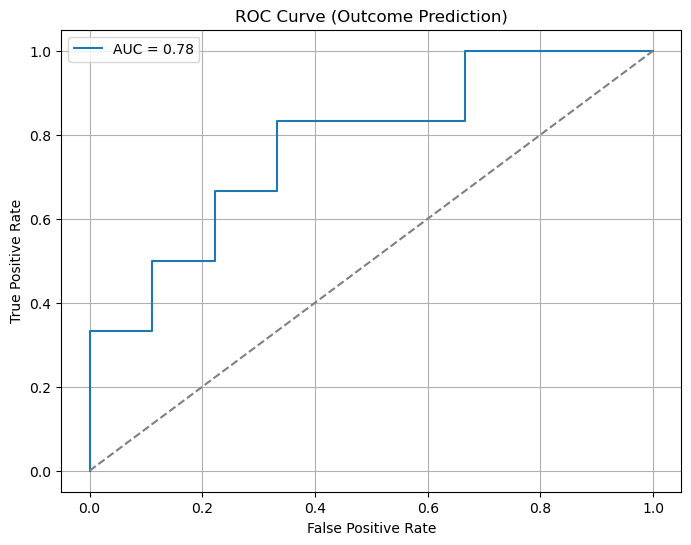

In [46]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Outcome Prediction)")
plt.legend()
plt.grid(True)
plt.show()

## 9. Confusion Matrix

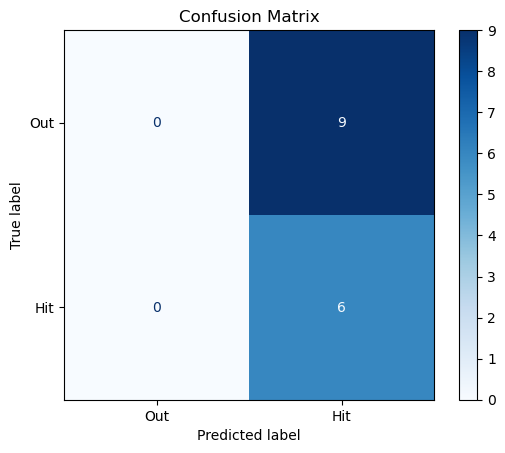

In [47]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Out", "Hit"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

My model correctly predicted 6 true hits as hits. However, it also predicted 9 true outs as hits. 

- 9 actual outs were incorrectly predicted as hits
- 6 actual hits were correctly predicted as hits

My model is conservative in calling hits (high bias toward predicting outs) and likely needs more refinement or context.

With that being said, I used a small sample size for this model implementation. I used the data from just one singular MLB game, with only 58 individual events. It is possible that over a larger sample size (multiple games or even a whole season), there would have been less bias toward predicting outs and the ensuing confusion matrix would have shown a more accurate prediction of outs as outs and hits as hits. 